In [131]:
import pandas as pd
from statsforecast import StatsForecast
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import time

# Modeling
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as statsmodelapi
from statsforecast import StatsForecast

# Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error,r2_score

In [132]:
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
dark_style = {
    'figure.facecolor': '#212946',
    'axes.facecolor': '#212946',
    'savefig.facecolor':'#212946',
    'axes.grid': True,
    'axes.grid.which': 'both',
    'axes.spines.left': False,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'axes.spines.bottom': False,
    'grid.color': '#2A3459',
    'grid.linewidth': '1',
    'text.color': '0.9',
    'axes.labelcolor': '0.9',
    'xtick.color': '0.9',
    'ytick.color': '0.9',
    'font.size': 12 }
plt.rcParams.update(dark_style)

from pylab import rcParams
rcParams['figure.figsize'] = (18,7)

### Custom functions

In [133]:
def adf_test(timeseries, valor_critico):
    print ('------- Resultados do Teste ADF: -------')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Teste Estatístico','P-Value','#Lags Usados','Número de observações usadas'])
    
    for key,value in dftest[4].items():
        dfoutput['Valor Crítico (%s)'%key] = value
        
    if dftest[1] < valor_critico: # Hipótese Nula
        dfoutput['-> Estacionária'] = True
    else: # Hipótese Alternativa
        dfoutput['-> Estacionária'] = False
        
    print (dfoutput)

def calculate_metrics(valid: list, predicted: list, model: str):
    """ Receives an array with the actual values and another array with the predicted values, 
    and uses them to calculate the main error metrics.
    
    Parameters 
    ----------
    valid
        array with actual values
    predicted
        array with predicted values
    model
        name of the model being used
    """
    
    mape = mean_absolute_percentage_error(valid, predicted, sample_weight=valid)
    mae = mean_absolute_error(valid, predicted)
    mse = mean_squared_error(valid, predicted)
    r2 = r2_score(valid, predicted)
    
    print(f"------------- Modelo {model} -------------")
    print(f"-> MAPE: {mape:.3%}")
    print(f"-> MAE: {mae}")
    print(f"-> MSE: {mse}")
    print(f"-> R2: {r2}")
    
    return mape,mae,mse,r2

def model_plot(train,test,model):
    """ Recebe um array com os valores de treino e os valores de teste (contendo uma coluna com os valores previstos).
    Utiliza as duas bases para construir um gráfico no qual se pode comparar visualmente a diferença entre os 
    valores reais e os preditos.
    
    Parâmetros 
    ----------
    train
        base de treino
    predicted
        base de testes contendo coluna com valores já preditos
    model
        nome do modelo sendo utilizado
    """
    df = pd.concat([train, test], ignore_index=True)
    fig = make_subplots()
    fig.add_trace(go.Scatter(x=df['ds'], y=df['y'], mode='lines', name='y'))

    fig.add_trace(go.Scatter(x=df['ds'], y=df['yhat'], mode='lines', name=model, line=dict(color='red')))

    fig.update_layout(
        title=f'Forecasting for {model} model',
        xaxis_title='Time [ds]',
        yaxis_title='Target [y]'
    )

    fig.show()

## Modeling

In [134]:
df = pd.read_csv("../data/processed/petroleum_price_ext.csv",
                                    sep=',',
                                    parse_dates=['date']
                                    )

In [135]:
df.rename(columns={"id": "unique_id",
                   "date":"ds",
                   "price":"y"}, inplace=True)
df.sort_values(by='ds', ascending=True, inplace=True)
df.reset_index(inplace=True)
df.drop(columns=["index"],inplace=True)
df.head()

,unique_id,ds,y,opec_price
0,Europe Brent Spot Price FOB (Dollars per Barrel),2021-01-04,50.37,51.35
1,Europe Brent Spot Price FOB (Dollars per Barrel),2021-01-05,53.16,50.75
2,Europe Brent Spot Price FOB (Dollars per Barrel),2021-01-06,53.80,53.29
3,Europe Brent Spot Price FOB (Dollars per Barrel),2021-01-07,53.70,53.84
4,Europe Brent Spot Price FOB (Dollars per Barrel),2021-01-08,55.51,54.39


In [136]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 753 entries, 0 to 752
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   unique_id   753 non-null    object        
 1   ds          753 non-null    datetime64[ns]
 2   y           753 non-null    float64       
 3   opec_price  753 non-null    float64       
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 23.7+ KB


Differencing

In [137]:
df_diff=df.copy()
df_diff['y_diff'] = df_diff['y'].diff()
df_diff.dropna(inplace=True)
df_diff.head()

,unique_id,ds,y,opec_price,y_diff
1,Europe Brent Spot Price FOB (Dollars per Barrel),2021-01-05,53.16,50.75,2.79
2,Europe Brent Spot Price FOB (Dollars per Barrel),2021-01-06,53.80,53.29,0.64
3,Europe Brent Spot Price FOB (Dollars per Barrel),2021-01-07,53.70,53.84,-0.10
4,Europe Brent Spot Price FOB (Dollars per Barrel),2021-01-08,55.51,54.39,1.81
5,Europe Brent Spot Price FOB (Dollars per Barrel),2021-01-11,54.84,54.76,-0.67


In [138]:
adf_test(df_diff['y_diff'], 0.05)

------- Resultados do Teste ADF: -------
Teste Estatístico              -13.711714
P-Value                               0.0
#Lags Usados                          5.0
Número de observações usadas        746.0
Valor Crítico (1%)              -3.439146
Valor Crítico (5%)              -2.865422
Valor Crítico (10%)             -2.568837
-> Estacionária                      True
dtype: object


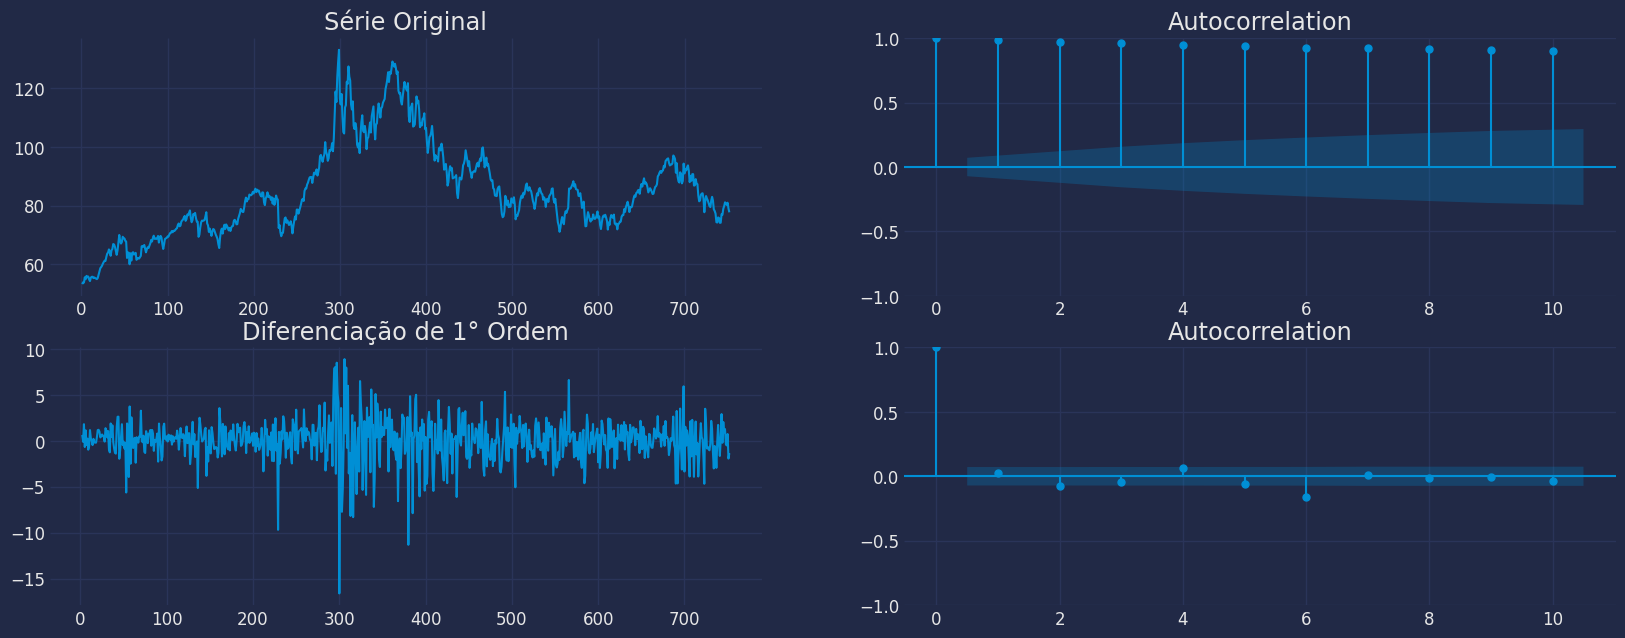

In [139]:
fig, axes = plt.subplots(2, 2, )
axes[0, 0].plot(df_diff["y"]); axes[0, 0].set_title('Série Original')
plot_acf(df_diff["y"], ax=axes[0, 1],lags=10)

axes[1, 0].plot(df_diff["y"].diff()); axes[1, 0].set_title('Diferenciação de 1° Ordem')
plot_acf(df_diff["y"].diff().dropna(), ax=axes[1, 1],lags=10)

plt.show()

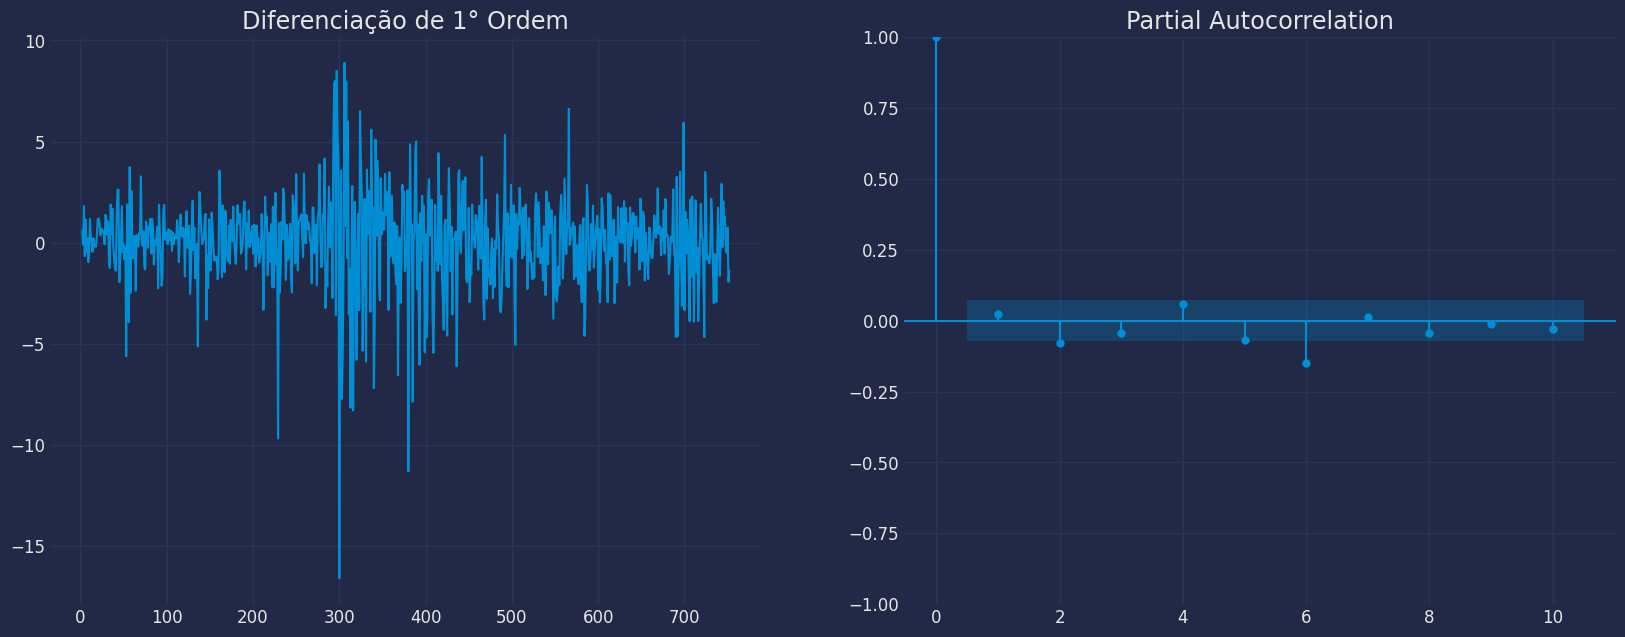

In [140]:
fig, axes = plt.subplots(1, 2)
axes[0].plot(df_diff["y"].diff()); axes[0].set_title('Diferenciação de 1° Ordem')
axes[1].set(ylim=(0,5))
plot_pacf(df_diff["y"].diff().dropna(), ax=axes[1],lags=10)

plt.show()

### Train & Test

In [141]:
train_size = df.shape[0] - 20
train, test = df[:train_size],df[train_size:]
shown_train = df[(train_size-80):train_size]
horizon = test.shape[0]

print(f"Tamanho da base de treino: {train.shape[0]}")
print(f"Tamanho da base de teste: {test.shape[0]}")
print(f"Tamanho da base de visualização: {shown_train.shape[0]}")
print(f"Horizonte: {horizon}")

Tamanho da base de treino: 733
Tamanho da base de teste: 20
Tamanho da base de visualização: 80
Horizonte: 20


### SARIMAX

In [142]:
exog_train = train[['opec_price']]
exog_test = test[['opec_price']]

In [148]:
exog_train

,opec_price
0,51.35
1,50.75
2,53.29
3,53.84
4,54.39
...,...
728,83.78
729,84.16
730,82.75
731,83.40


In [143]:
train

,unique_id,ds,y,opec_price
0,Europe Brent Spot Price FOB (Dollars per Barrel),2021-01-04,50.37,51.35
1,Europe Brent Spot Price FOB (Dollars per Barrel),2021-01-05,53.16,50.75
2,Europe Brent Spot Price FOB (Dollars per Barrel),2021-01-06,53.80,53.29
3,Europe Brent Spot Price FOB (Dollars per Barrel),2021-01-07,53.70,53.84
4,Europe Brent Spot Price FOB (Dollars per Barrel),2021-01-08,55.51,54.39
...,...,...,...,...
728,Europe Brent Spot Price FOB (Dollars per Barrel),2023-11-23,80.85,83.78
729,Europe Brent Spot Price FOB (Dollars per Barrel),2023-11-24,79.82,84.16
730,Europe Brent Spot Price FOB (Dollars per Barrel),2023-11-27,79.49,82.75
731,Europe Brent Spot Price FOB (Dollars per Barrel),2023-11-28,81.66,83.40


In [144]:
test

,unique_id,ds,y,opec_price
733,Europe Brent Spot Price FOB (Dollars per Barrel),2023-11-30,81.72,85.00
734,Europe Brent Spot Price FOB (Dollars per Barrel),2023-12-01,78.72,82.54
735,Europe Brent Spot Price FOB (Dollars per Barrel),2023-12-04,78.16,79.63
736,Europe Brent Spot Price FOB (Dollars per Barrel),2023-12-05,77.27,79.96
737,Europe Brent Spot Price FOB (Dollars per Barrel),2023-12-06,74.33,78.26
738,Europe Brent Spot Price FOB (Dollars per Barrel),2023-12-07,74.21,76.37
739,Europe Brent Spot Price FOB (Dollars per Barrel),2023-12-08,75.94,77.42
740,Europe Brent Spot Price FOB (Dollars per Barrel),2023-12-11,75.75,77.93
741,Europe Brent Spot Price FOB (Dollars per Barrel),2023-12-12,74.11,77.01
742,Europe Brent Spot Price FOB (Dollars per Barrel),2023-12-13,74.14,73.91


In [145]:
start_model_sarimax = time.time()
model_sarimax = statsmodelapi.tsa.statespace.SARIMAX(
    endog=train["y"], 
    exog=exog_train, 
    order=[1, 1, 1], 
    seasonal_order=[1, 1, 1, 5]
)
results = model_sarimax.fit()
forecast_predictions = results.get_forecast(steps=len(test), exog=exog_test).predicted_mean
end_model_sarimax = time.time()

y_true = test["y"]
y_pred = forecast_predictions

total_time_sarimax = end_model_sarimax - start_model_sarimax
sarimax_metrics = calculate_metrics(valid=y_true, predicted=y_pred, model="SARIMAX")
print(f"=== Tempo gasto: {total_time_sarimax}")

------------- Modelo SARIMAX -------------
-> MAPE: 1.519%
-> MAE: 1.1824185305317996
-> MSE: 1.8853358329499055
-> R2: 0.6855989254651725
=== Tempo gasto: 1.3374426364898682


In [146]:
test['yhat'] = forecast_predictions

C:\Users\jessi\AppData\Local\Temp\ipykernel_26628\1921132725.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [147]:
model_plot(shown_train, test,'SARIMAX')